In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.cat_boost import CatBoostEncoder
import lightgbm as lbm
from lightgbm import LGBMModel, LGBMRegressor

In [2]:
train = pd.read_csv('train.csv')
test=  pd.read_csv('test.csv')

train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]
test_x = test.drop(['price'], axis = 1)
test_y = np.sqrt(test.loc[:, ['price']])

feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

best_lgbm_reg = LGBMRegressor(learning_rate = 0.3)
best_lgbm_reg.fit(train_cbe, train_y)

LGBMRegressor(learning_rate=0.3)

In [3]:
#1.1
import pickle
import joblib

with open('lgbm.pkl', 'rb') as f:
    model = pickle.load(f)
model

LGBMRegressor(learning_rate=0.3)

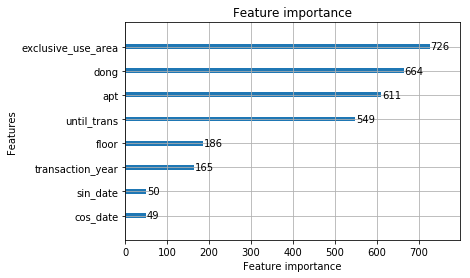

In [4]:
lbm.plot_importance(model)

지니불순도 - tree의 노드에 샘플들이 이질적으로 구성되어 있을 경우 지니 불순도는 높아진다.


lightgbm은 tree 형태의 모델인데, 이 tree에서 exclusive_use_area 변수가 불순도를 가장 크게 감소시킨다고 해석할 수 있다

In [5]:
#1.3
import os
import random
random.seed(42)
np.random.seed(42)


In [6]:
#1.4
from sklearn.inspection import permutation_importance
res = permutation_importance(best_lgbm_reg,test_cbe, test_y)

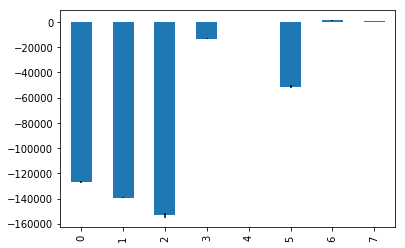

In [7]:
imp = pd.Series(res.importances_mean)
imp.plot.bar(yerr=res.importances_std)

In [8]:
#1.5
import shap
explainer = shap.TreeExplainer(best_lgbm_reg)
shap_values = explainer.shap_values(train_cbe)

C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

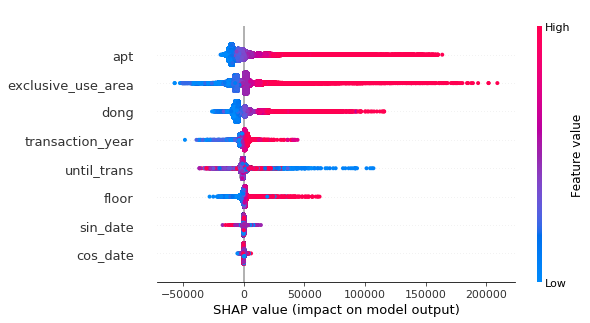

In [9]:
shap.summary_plot(shap_values, train_cbe)

apt,exclusive_use_area, dong, transaction_year,floor 변수의 값이 높을수록 가격이 높은 경향이 있다

until_trans 변수의 값이 낮을수록 예상 가격이 높은 경향성이 있다

나머지 변수는 상관성을 파악하기 어렵다

In [10]:
#2.1
train = pd.read_csv('train.csv')
train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]

val_x = train_x[train['transaction_year'] == 4]
val_y = train_y[train['transaction_year'] == 4]
train_tune_x = train_x[train['transaction_year'] < 4]
train_tune_y = train_y[train['transaction_year'] < 4]

CBE_encoder = CatBoostEncoder()
train_tune_cbe = CBE_encoder.fit_transform(train_tune_x[feature_list], train_tune_y)
val_cbe = CBE_encoder.transform(val_x[feature_list])

In [11]:
import tensorflow as tf
import keras
from keras import metrics
from keras import models
from keras import layers
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [12]:
def build_model():
    model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = keras.optimizers.RMSprop(0.0001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
    return model

In [13]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2304      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________


4개의 hiddden layer로 구성되어 있으며 각 layer는 256, 64, 32, 1개의 output을 결과로 낸다.

In [14]:
#2.2
history = model.fit(train_tune_cbe, train_tune_y, epochs=300, validation_data = (val_cbe, val_y), batch_size = 512)

W0506 10:25:16.741983 25320 deprecation_wrapper.py:119] From C:\Users\vbnmz\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 312466 samples, validate on 109698 samples
Epoch 1/300
312466/312466 [==============================] - 2s 6us/step - loss: 441217023.0497 - mse: 441216960.0000 - val_loss: 326224818.8672 - val_mse: 326224800.0000
Epoch 2/300
312466/312466 [==============================] - 2s 5us/step - loss: 232555916.7627 - mse: 232555904.0000 - val_loss: 341022206.0873 - val_mse: 341022272.0000
Epoch 3/300
312466/312466 [==============================] - 2s 5us/step - loss: 232284114.9962 - mse: 232284032.0000 - val_loss: 342789922.0347 - val_mse: 342789888.0000
Epoch 4/300
312466/312466 [==============================] - 2s 5us/step - loss: 231966956.5652 - mse: 231966944.0000 - val_loss: 327348914.0440 - val_mse: 327348960.0000
Epoch 5/300
312466/312466 [==============================] - 2s 5us/step - loss: 231694103.3777 - mse: 231694160.0000 - val_loss: 324929219.1986 - val_mse: 324929120.0000
Epoch 6/300
312466/312466 [==============================] - 1s 5us/step - loss: 231284568.49

Epoch 96/300
312466/312466 [==============================] - 2s 5us/step - loss: 182237302.3062 - mse: 182237408.0000 - val_loss: 270191626.1681 - val_mse: 270191680.0000
Epoch 97/300
312466/312466 [==============================] - 2s 5us/step - loss: 181981101.9646 - mse: 181981088.0000 - val_loss: 243621566.1958 - val_mse: 243621584.0000
Epoch 98/300
312466/312466 [==============================] - 2s 5us/step - loss: 181797624.6689 - mse: 181797632.0000 - val_loss: 340156683.3843 - val_mse: 340156640.0000
Epoch 99/300
312466/312466 [==============================] - 2s 5us/step - loss: 181668375.4605 - mse: 181668368.0000 - val_loss: 309236779.5526 - val_mse: 309236832.0000
Epoch 100/300
312466/312466 [==============================] - 2s 5us/step - loss: 181535665.7958 - mse: 181535728.0000 - val_loss: 313228229.1490 - val_mse: 313228224.0000
Epoch 101/300
312466/312466 [==============================] - 2s 5us/step - loss: 181182159.9678 - mse: 181182112.0000 - val_loss: 2597485

Method (on_train_batch_end) is slow compared to the batch update (0.150597). Check your callbacks.


312466/312466 [==============================] - 3s 10us/step - loss: 172386572.5361 - mse: 172386592.0000 - val_loss: 302890900.6805 - val_mse: 302890912.0000
Epoch 183/300
312466/312466 [==============================] - 3s 9us/step - loss: 172316842.0457 - mse: 172316880.0000 - val_loss: 298227025.8445 - val_mse: 298226976.0000
Epoch 184/300
312466/312466 [==============================] - 3s 9us/step - loss: 171821535.2138 - mse: 171821648.0000 - val_loss: 345358749.1567 - val_mse: 345358688.0000
Epoch 185/300
312466/312466 [==============================] - 3s 9us/step - loss: 171805208.8058 - mse: 171805312.0000 - val_loss: 296733689.1107 - val_mse: 296733696.0000
Epoch 186/300
312466/312466 [==============================] - 2s 8us/step - loss: 171850121.3347 - mse: 171850112.0000 - val_loss: 382088166.8292 - val_mse: 382088192.0000
Epoch 187/300
312466/312466 [==============================] - 2s 8us/step - loss: 171740961.0200 - mse: 171740944.0000 - val_loss: 373454365.0499 -

312466/312466 [==============================] - 2s 6us/step - loss: 161966049.3543 - mse: 161966016.0000 - val_loss: 333567176.7318 - val_mse: 333567264.0000
Epoch 277/300
312466/312466 [==============================] - 2s 6us/step - loss: 162218155.7639 - mse: 162218176.0000 - val_loss: 269880365.0356 - val_mse: 269880352.0000
Epoch 278/300
312466/312466 [==============================] - 2s 6us/step - loss: 162001717.7565 - mse: 162001696.0000 - val_loss: 349224401.5280 - val_mse: 349224512.0000
Epoch 279/300
312466/312466 [==============================] - 2s 5us/step - loss: 161736248.1620 - mse: 161736160.0000 - val_loss: 233448520.5728 - val_mse: 233448528.0000
Epoch 280/300
312466/312466 [==============================] - 2s 6us/step - loss: 161742669.4588 - mse: 161742800.0000 - val_loss: 219177318.1364 - val_mse: 219177376.0000
Epoch 281/300
312466/312466 [==============================] - 2s 5us/step - loss: 161668948.8492 - mse: 161668960.0000 - val_loss: 330252197.0195 - 

In [15]:
val_loss = history.history['val_loss']
loss = history.history['loss']

Text(0, 0.5, 'loss')

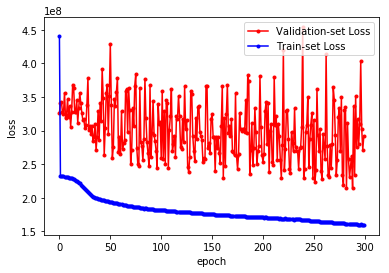

In [16]:
plt.plot(val_loss, marker='.', c='red', label="Validation-set Loss")
plt.plot(loss, marker='.', c='blue', label="Train-set Loss")
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')

lgbm의 validation mse가 1.2*10^8, 딥러닝 모델의 validation mse가 2.7*10^8으로 딥러닝 모델이 더 크다

그리고 딥러닝 모델의 경우 validation loss가 위아래로 진동하고 있어 학습이 원활하게 되지 않는 모습이다

In [23]:
def build_model():
    model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = keras.optimizers.RMSprop(0.0001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
    return model


In [42]:
model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 256)               2304      
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_________________________________________________________________
dense_30 (Dense)             (None, 32)               

In [44]:
history = model.fit(train_tune_cbe, train_tune_y, epochs=100, validation_data = (val_cbe, val_y), batch_size = 512)

Train on 312466 samples, validate on 109698 samples
Epoch 1/100
312466/312466 [==============================] - 10s 32us/step - loss: 3074447091.9646 - mse: 3074447360.0000 - val_loss: 4169109251.5752 - val_mse: 4169109760.0000
Epoch 2/100
312466/312466 [==============================] - 9s 29us/step - loss: 3072440057.7881 - mse: 3072440832.0000 - val_loss: 4165958663.3604 - val_mse: 4165958656.0000
Epoch 3/100
312466/312466 [==============================] - 9s 29us/step - loss: 3069326196.8142 - mse: 3069327104.0000 - val_loss: 4161366410.1305 - val_mse: 4161366528.0000
Epoch 4/100
312466/312466 [==============================] - 10s 31us/step - loss: 3064889397.9699 - mse: 3064890624.0000 - val_loss: 4155142700.1019 - val_mse: 4155142912.0000
Epoch 5/100
312466/312466 [==============================] - 10s 32us/step - loss: 3058832599.7860 - mse: 3058832384.0000 - val_loss: 4147097633.2969 - val_mse: 4147097856.0000oss: 3073971161.9861 - mse: 30 - ETA: 1s - loss: 306
Epoch 6/100
3

312466/312466 [==============================] - 8s 27us/step - loss: 243514593.4736 - mse: 243514720.0000 - val_loss: 216529779.1242 - val_mse: 216529728.0000
Epoch 47/100
312466/312466 [==============================] - 9s 30us/step - loss: 210621574.3949 - mse: 210621504.0000 - val_loss: 404642223.2016 - val_mse: 404642240.0000
Epoch 48/100
312466/312466 [==============================] - 8s 26us/step - loss: 191761468.5850 - mse: 191761440.0000 - val_loss: 303894679.2093 - val_mse: 303894752.0000
Epoch 49/100
312466/312466 [==============================] - 8s 25us/step - loss: 180322010.9611 - mse: 180322128.0000 - val_loss: 272483665.8194 - val_mse: 272483648.0000
Epoch 50/100
312466/312466 [==============================] - 8s 26us/step - loss: 174000673.3798 - mse: 174000672.0000 - val_loss: 225601631.8531 - val_mse: 225601600.0000
Epoch 51/100
312466/312466 [==============================] - 8s 27us/step - loss: 170486467.3908 - mse: 170486528.0000 - val_loss: 196886471.6332 -

Text(0, 0.5, 'loss')

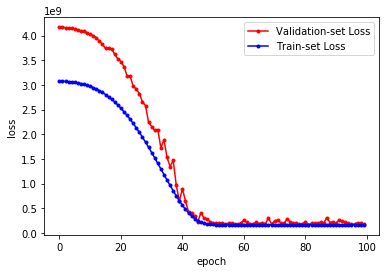

In [46]:
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(val_loss, marker='.', c='red', label="Validation-set Loss")
plt.plot(loss, marker='.', c='blue', label="Train-set Loss")
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
199571209